In [2]:
# notebooks/02_autocorrelation_analysis.ipynb
"""
# ADIA Lab Structural Break Challenge - Comprehensive Autocorrelation Analysis

This notebook performs in-depth autocorrelation analysis to understand:
1. General autocorrelation patterns in the time series
2. Differences in autocorrelation between series with and without breaks
3. Changes in autocorrelation before and after boundary points
4. Statistical significance of autocorrelation patterns
"""

'\n# ADIA Lab Structural Break Challenge - Comprehensive Autocorrelation Analysis\n\nThis notebook performs in-depth autocorrelation analysis to understand:\n1. General autocorrelation patterns in the time series\n2. Differences in autocorrelation between series with and without breaks\n3. Changes in autocorrelation before and after boundary points\n4. Statistical significance of autocorrelation patterns\n'

1. Setup and Imports

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
import scipy.stats as stats
import warnings
warnings.filterwarnings('ignore')

# Import our custom data loader
import sys
sys.path.append('..')
from src.data.dataLoader import StructuralBreakDataLoader

# Configure plotting
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (14, 8)

2. Load Data Using Our Data Class

In [4]:
# Initialize data loader
loader = StructuralBreakDataLoader(data_dir="../data")

# Load data
X_train, y_train, X_test = loader.load_data(use_crunch=False)

# Get dataset statistics
stats_info = loader.get_statistics()
print("Dataset Statistics:")
for key, value in stats_info.items():
    if not isinstance(value, list):
        print(f"  {key}: {value}")

# Get positive and negative examples
positive_examples = loader.get_positive_examples()
negative_examples = loader.get_negative_examples()

print(f"\nPositive examples (with break): {len(positive_examples)}")
print(f"Negative examples (no break): {len(negative_examples)}")

INFO:src.data.dataLoader:Data loaded successfully from local files


Dataset Statistics:
  n_train_series: 10001
  n_test_series: 101
  n_positive: 2909
  n_negative: 7092
  positive_ratio: 0.29087091290870914
  min_length: 1258
  max_length: 3478
  mean_length: 2371.336266373363
  std_length: 482.62180497047103

Positive examples (with break): 2909
Negative examples (no break): 7092


3. Basic Autocorrelation Analysis

In [5]:
def compute_autocorrelations(series_dict, max_lags=50):
    """
    Compute autocorrelations for a dictionary of time series.
    
    Args:
        series_dict: Dictionary of TimeSeriesData objects
        max_lags: Maximum number of lags to compute
        
    Returns:
        Dictionary with autocorrelation results
    """
    autocorrelations = []
    series_lengths = []
    
    for series_id, ts_data in series_dict.items():
        if len(ts_data.values) > max_lags:
            # Compute ACF
            acf_values = acf(ts_data.values, nlags=max_lags, fft=True)
            autocorrelations.append(acf_values)
            series_lengths.append(len(ts_data.values))
    
    if not autocorrelations:
        return None
    
    # Convert to numpy array
    acf_matrix = np.array(autocorrelations)
    
    return {
        'acf_matrix': acf_matrix,
        'mean_acf': np.mean(acf_matrix, axis=0),
        'std_acf': np.std(acf_matrix, axis=0),
        'min_acf': np.min(acf_matrix, axis=0),
        'max_acf': np.max(acf_matrix, axis=0),
        'n_series': len(autocorrelations),
        'series_lengths': series_lengths
    }

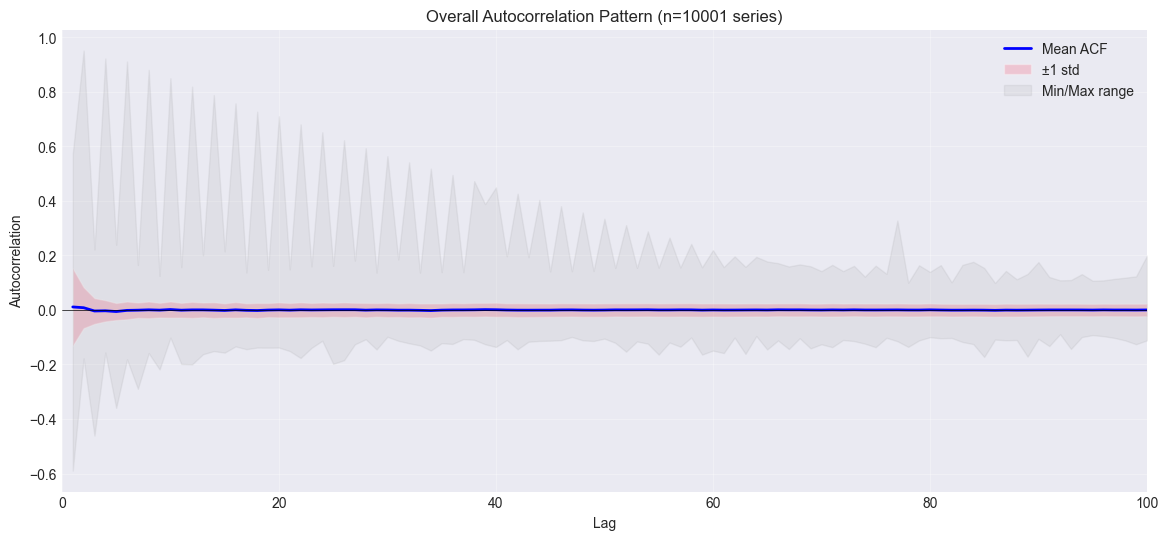

In [6]:
# Compute autocorrelations for all training data
max_lags = 100
all_series_acf = compute_autocorrelations(loader.get_all_train_series(), max_lags)

# Plot overall autocorrelation patterns
lags = np.arange(0, max_lags + 1)

plt.figure(figsize=(14, 6))

# Plot mean with confidence bands
plt.plot(lags[1:], all_series_acf['mean_acf'][1:], 'b-', linewidth=2, label='Mean ACF')
plt.fill_between(lags[1:], 
                 all_series_acf['mean_acf'][1:] - all_series_acf['std_acf'][1:],
                 all_series_acf['mean_acf'][1:] + all_series_acf['std_acf'][1:],
                 alpha=0.3, label='±1 std')

# Add min/max envelope
plt.fill_between(lags[1:], 
                 all_series_acf['min_acf'][1:],
                 all_series_acf['max_acf'][1:],
                 alpha=0.1, color='gray', label='Min/Max range')

plt.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title(f'Overall Autocorrelation Pattern (n={all_series_acf["n_series"]} series)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim(0, max_lags)
plt.show()

4. Compare Autocorrelation: Break vs No Break

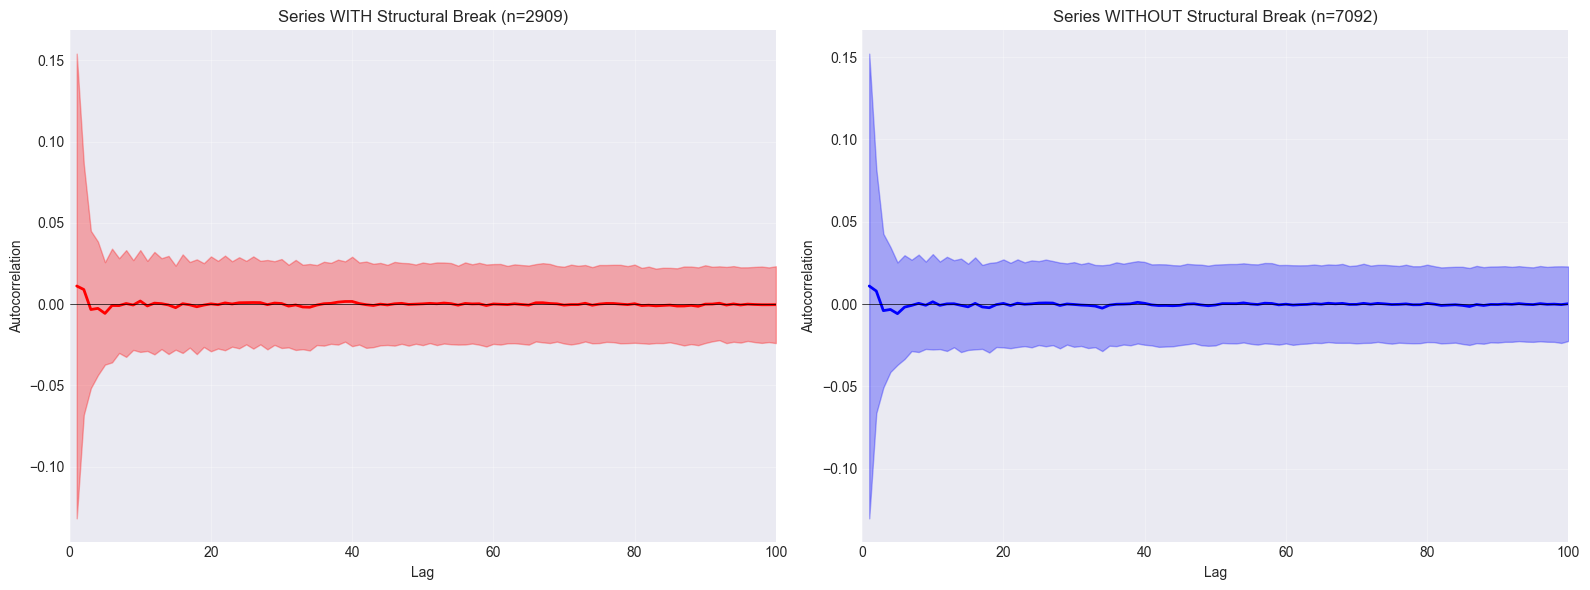

In [7]:
# Compute autocorrelations separately for positive and negative examples
positive_acf = compute_autocorrelations(positive_examples, max_lags)
negative_acf = compute_autocorrelations(negative_examples, max_lags)

# Plot comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot positive examples (with break)
ax1.plot(lags[1:], positive_acf['mean_acf'][1:], 'r-', linewidth=2, label='Mean ACF')
ax1.fill_between(lags[1:], 
                 positive_acf['mean_acf'][1:] - positive_acf['std_acf'][1:],
                 positive_acf['mean_acf'][1:] + positive_acf['std_acf'][1:],
                 alpha=0.3, color='red')
ax1.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax1.set_xlabel('Lag')
ax1.set_ylabel('Autocorrelation')
ax1.set_title(f'Series WITH Structural Break (n={positive_acf["n_series"]})')
ax1.grid(True, alpha=0.3)
ax1.set_xlim(0, max_lags)

# Plot negative examples (no break)
ax2.plot(lags[1:], negative_acf['mean_acf'][1:], 'b-', linewidth=2, label='Mean ACF')
ax2.fill_between(lags[1:], 
                 negative_acf['mean_acf'][1:] - negative_acf['std_acf'][1:],
                 negative_acf['mean_acf'][1:] + negative_acf['std_acf'][1:],
                 alpha=0.3, color='blue')
ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax2.set_xlabel('Lag')
ax2.set_ylabel('Autocorrelation')
ax2.set_title(f'Series WITHOUT Structural Break (n={negative_acf["n_series"]})')
ax2.grid(True, alpha=0.3)
ax2.set_xlim(0, max_lags)

plt.tight_layout()
plt.show()

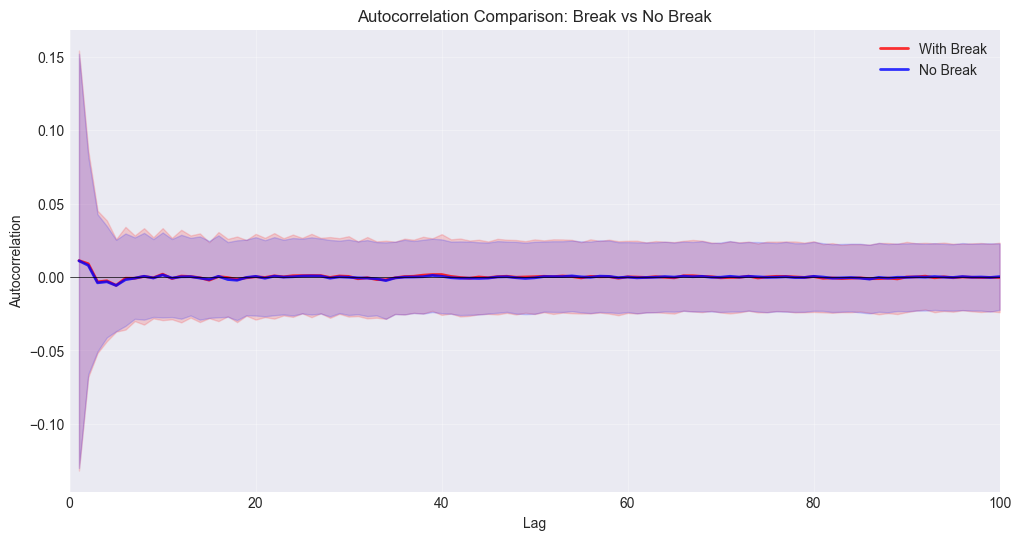

Statistical test for ACF differences at various lags:
Lag 1: U-statistic = 10317758.00, p-value = 0.9851
Lag 5: U-statistic = 10403476.00, p-value = 0.5014
Lag 10: U-statistic = 10394545.00, p-value = 0.5457
Lag 20: U-statistic = 10218173.00, p-value = 0.4588
Lag 50: U-statistic = 10455434.00, p-value = 0.2853


In [8]:
# Direct comparison overlay
plt.figure(figsize=(12, 6))
plt.plot(lags[1:], positive_acf['mean_acf'][1:], 'r-', linewidth=2, label='With Break', alpha=0.8)
plt.plot(lags[1:], negative_acf['mean_acf'][1:], 'b-', linewidth=2, label='No Break', alpha=0.8)

# Add confidence bands
plt.fill_between(lags[1:], 
                 positive_acf['mean_acf'][1:] - positive_acf['std_acf'][1:],
                 positive_acf['mean_acf'][1:] + positive_acf['std_acf'][1:],
                 alpha=0.15, color='red')
plt.fill_between(lags[1:], 
                 negative_acf['mean_acf'][1:] - negative_acf['std_acf'][1:],
                 negative_acf['mean_acf'][1:] + negative_acf['std_acf'][1:],
                 alpha=0.15, color='blue')

plt.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Comparison: Break vs No Break')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim(0, max_lags)
plt.show()

# Statistical test for difference
print("Statistical test for ACF differences at various lags:")
test_lags = [1, 5, 10, 20, 50]
for lag in test_lags:
    if lag <= max_lags:
        # Mann-Whitney U test for difference in ACF at specific lag
        u_stat, p_value = stats.mannwhitneyu(
            positive_acf['acf_matrix'][:, lag],
            negative_acf['acf_matrix'][:, lag]
        )
        print(f"Lag {lag}: U-statistic = {u_stat:.2f}, p-value = {p_value:.4f}")

5. Autocorrelation Before and After Boundary Point

In [9]:
def compute_period_autocorrelations(series_dict, max_lags=30):
    """
    Compute autocorrelations separately for period 0 and period 1.
    """
    period_0_acf = []
    period_1_acf = []
    
    for series_id, ts_data in series_dict.items():
        # Period 0 autocorrelation
        if len(ts_data.period_0_values) > max_lags:
            acf_p0 = acf(ts_data.period_0_values, nlags=max_lags, fft=True)
            period_0_acf.append(acf_p0)
        
        # Period 1 autocorrelation
        if len(ts_data.period_1_values) > max_lags:
            acf_p1 = acf(ts_data.period_1_values, nlags=max_lags, fft=True)
            period_1_acf.append(acf_p1)
    
    result = {}
    if period_0_acf:
        acf_matrix_p0 = np.array(period_0_acf)
        result['period_0'] = {
            'mean_acf': np.mean(acf_matrix_p0, axis=0),
            'std_acf': np.std(acf_matrix_p0, axis=0),
            'n_series': len(period_0_acf)
        }
    
    if period_1_acf:
        acf_matrix_p1 = np.array(period_1_acf)
        result['period_1'] = {
            'mean_acf': np.mean(acf_matrix_p1, axis=0),
            'std_acf': np.std(acf_matrix_p1, axis=0),
            'n_series': len(period_1_acf)
        }
    
    return result

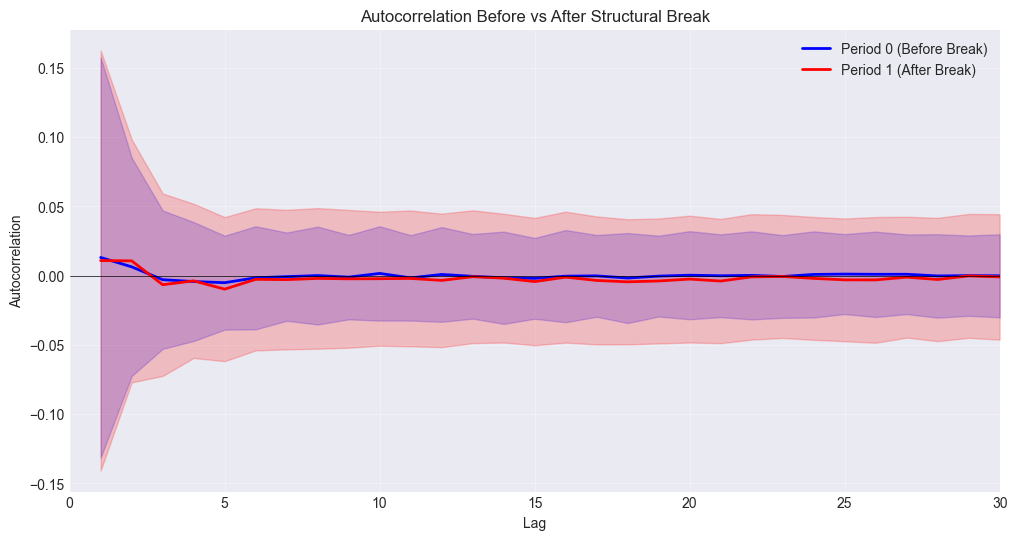

In [10]:
# Analyze autocorrelation changes for series with breaks
max_lags_period = 30  # Smaller because periods are shorter
positive_period_acf = compute_period_autocorrelations(positive_examples, max_lags_period)

lags_period = np.arange(0, max_lags_period + 1)

plt.figure(figsize=(12, 6))

# Plot Period 0 (before break)
if 'period_0' in positive_period_acf:
    plt.plot(lags_period[1:], positive_period_acf['period_0']['mean_acf'][1:], 
             'b-', linewidth=2, label='Period 0 (Before Break)')
    plt.fill_between(lags_period[1:], 
                     positive_period_acf['period_0']['mean_acf'][1:] - positive_period_acf['period_0']['std_acf'][1:],
                     positive_period_acf['period_0']['mean_acf'][1:] + positive_period_acf['period_0']['std_acf'][1:],
                     alpha=0.2, color='blue')

# Plot Period 1 (after break)
if 'period_1' in positive_period_acf:
    plt.plot(lags_period[1:], positive_period_acf['period_1']['mean_acf'][1:], 
             'r-', linewidth=2, label='Period 1 (After Break)')
    plt.fill_between(lags_period[1:], 
                     positive_period_acf['period_1']['mean_acf'][1:] - positive_period_acf['period_1']['std_acf'][1:],
                     positive_period_acf['period_1']['mean_acf'][1:] + positive_period_acf['period_1']['std_acf'][1:],
                     alpha=0.2, color='red')

plt.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Before vs After Structural Break')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim(0, max_lags_period)
plt.show()

6. Partial Autocorrelation Analysis

In [11]:
def compute_partial_autocorrelations(series_dict, max_lags=30):
    """
    Compute partial autocorrelations for time series.
    """
    pacf_values = []
    
    for series_id, ts_data in series_dict.items():
        if len(ts_data.values) > max_lags * 2:  # Need more data for PACF
            try:
                pacf_vals = pacf(ts_data.values, nlags=max_lags)
                pacf_values.append(pacf_vals)
            except:
                continue
    
    if not pacf_values:
        return None
    
    pacf_matrix = np.array(pacf_values)
    return {
        'pacf_matrix': pacf_matrix,
        'mean_pacf': np.mean(pacf_matrix, axis=0),
        'std_pacf': np.std(pacf_matrix, axis=0),
        'n_series': len(pacf_values)
    }

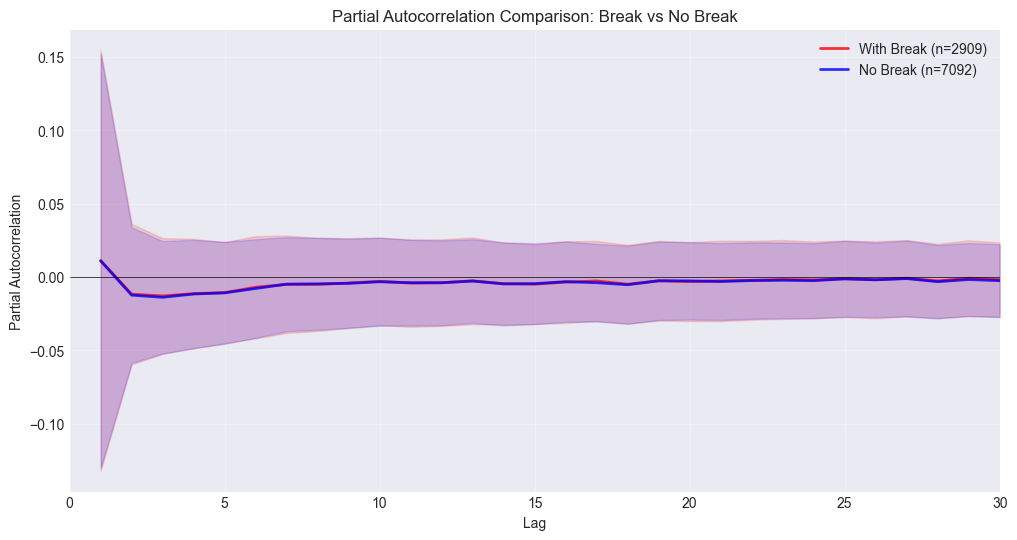

In [12]:
# Compute PACF for positive and negative examples
pacf_lags = 30
positive_pacf = compute_partial_autocorrelations(positive_examples, pacf_lags)
negative_pacf = compute_partial_autocorrelations(negative_examples, pacf_lags)

# Plot PACF comparison
plt.figure(figsize=(12, 6))
lags_pacf = np.arange(0, pacf_lags + 1)

if positive_pacf:
    plt.plot(lags_pacf[1:], positive_pacf['mean_pacf'][1:], 'r-', linewidth=2, 
             label=f'With Break (n={positive_pacf["n_series"]})', alpha=0.8)
    plt.fill_between(lags_pacf[1:], 
                     positive_pacf['mean_pacf'][1:] - positive_pacf['std_pacf'][1:],
                     positive_pacf['mean_pacf'][1:] + positive_pacf['std_pacf'][1:],
                     alpha=0.15, color='red')

if negative_pacf:
    plt.plot(lags_pacf[1:], negative_pacf['mean_pacf'][1:], 'b-', linewidth=2, 
             label=f'No Break (n={negative_pacf["n_series"]})', alpha=0.8)
    plt.fill_between(lags_pacf[1:], 
                     negative_pacf['mean_pacf'][1:] - negative_pacf['std_pacf'][1:],
                     negative_pacf['mean_pacf'][1:] + negative_pacf['std_pacf'][1:],
                     alpha=0.15, color='blue')

plt.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.title('Partial Autocorrelation Comparison: Break vs No Break')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim(0, pacf_lags)
plt.show()

7. Statistical Tests for Autocorrelation

In [13]:
def ljung_box_test_analysis(series_dict, max_lag=20):
    """
    Perform Ljung-Box test for autocorrelation significance.
    """
    p_values = []
    
    for series_id, ts_data in series_dict.items():
        if len(ts_data.values) > max_lag * 2:
            # Ljung-Box test
            result = acorr_ljungbox(ts_data.values, lags=max_lag, return_df=True)
            p_values.append(result['lb_pvalue'].values)
    
    if not p_values:
        return None
    
    p_values_matrix = np.array(p_values)
    return {
        'mean_pvalues': np.mean(p_values_matrix, axis=0),
        'percent_significant': np.mean(p_values_matrix < 0.05, axis=0) * 100,
        'n_series': len(p_values)
    }

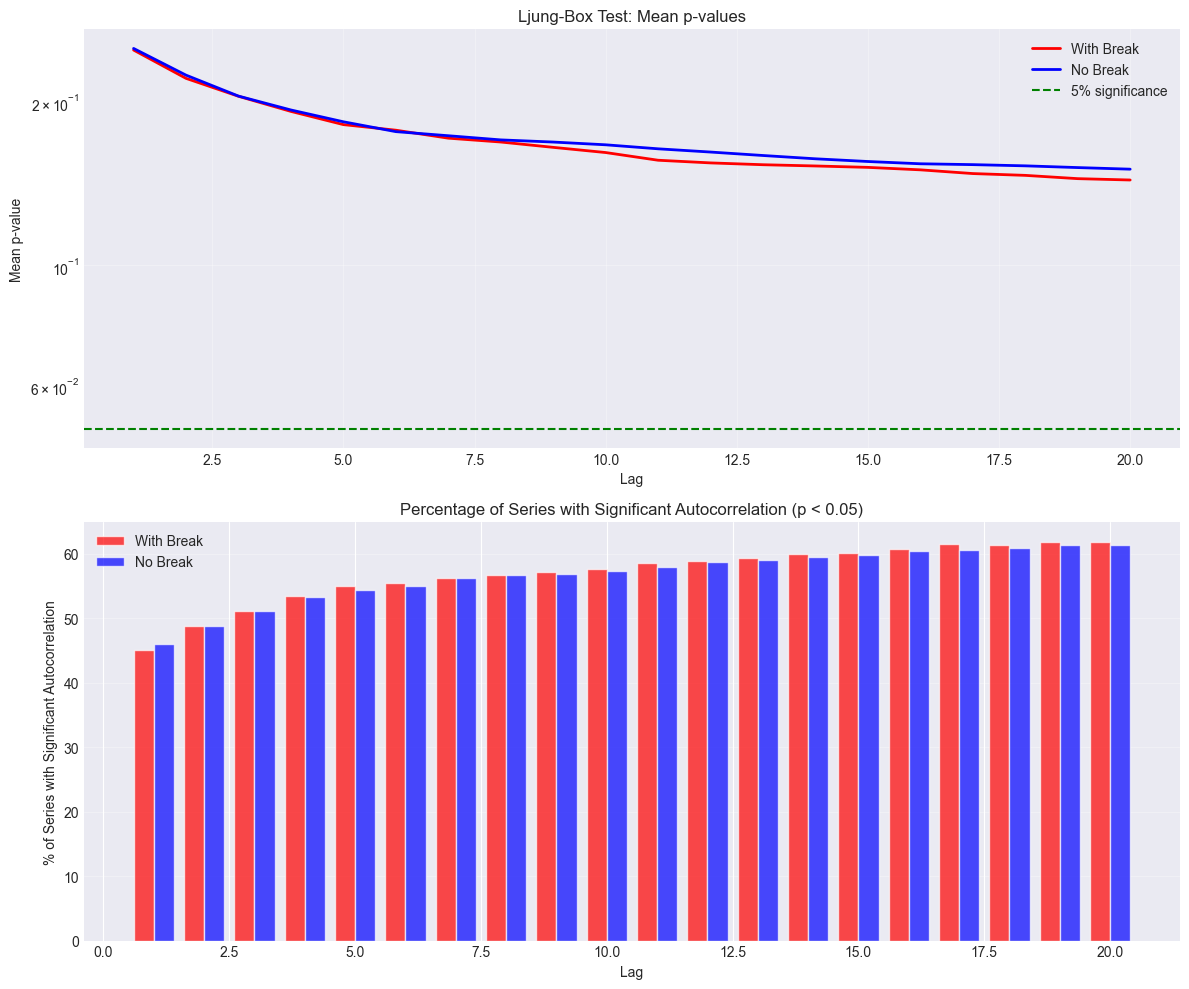

In [14]:
# Perform Ljung-Box test
lb_positive = ljung_box_test_analysis(positive_examples)
lb_negative = ljung_box_test_analysis(negative_examples)

# Plot results
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
test_lags = np.arange(1, 21)

# Plot mean p-values
ax1.plot(test_lags, lb_positive['mean_pvalues'], 'r-', linewidth=2, label='With Break')
ax1.plot(test_lags, lb_negative['mean_pvalues'], 'b-', linewidth=2, label='No Break')
ax1.axhline(y=0.05, color='green', linestyle='--', label='5% significance')
ax1.set_xlabel('Lag')
ax1.set_ylabel('Mean p-value')
ax1.set_title('Ljung-Box Test: Mean p-values')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_yscale('log')

# Plot percentage of significant series
ax2.bar(test_lags - 0.2, lb_positive['percent_significant'], width=0.4, 
        color='red', alpha=0.7, label='With Break')
ax2.bar(test_lags + 0.2, lb_negative['percent_significant'], width=0.4, 
        color='blue', alpha=0.7, label='No Break')
ax2.set_xlabel('Lag')
ax2.set_ylabel('% of Series with Significant Autocorrelation')
ax2.set_title('Percentage of Series with Significant Autocorrelation (p < 0.05)')
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

8. Autocorrelation Decay Analysis

In [15]:
def analyze_acf_decay(series_dict, threshold=0.1, max_lags=100):
    """
    Analyze how quickly autocorrelation decays below a threshold.
    """
    decay_lags = []
    
    for series_id, ts_data in series_dict.items():
        if len(ts_data.values) > max_lags:
            acf_values = acf(ts_data.values, nlags=max_lags, fft=True)
            
            # Find first lag where |ACF| < threshold
            below_threshold = np.where(np.abs(acf_values[1:]) < threshold)[0]
            if len(below_threshold) > 0:
                decay_lag = below_threshold[0] + 1
                decay_lags.append(decay_lag)
            else:
                decay_lags.append(max_lags)  # Didn't decay within max_lags
    
    return decay_lags

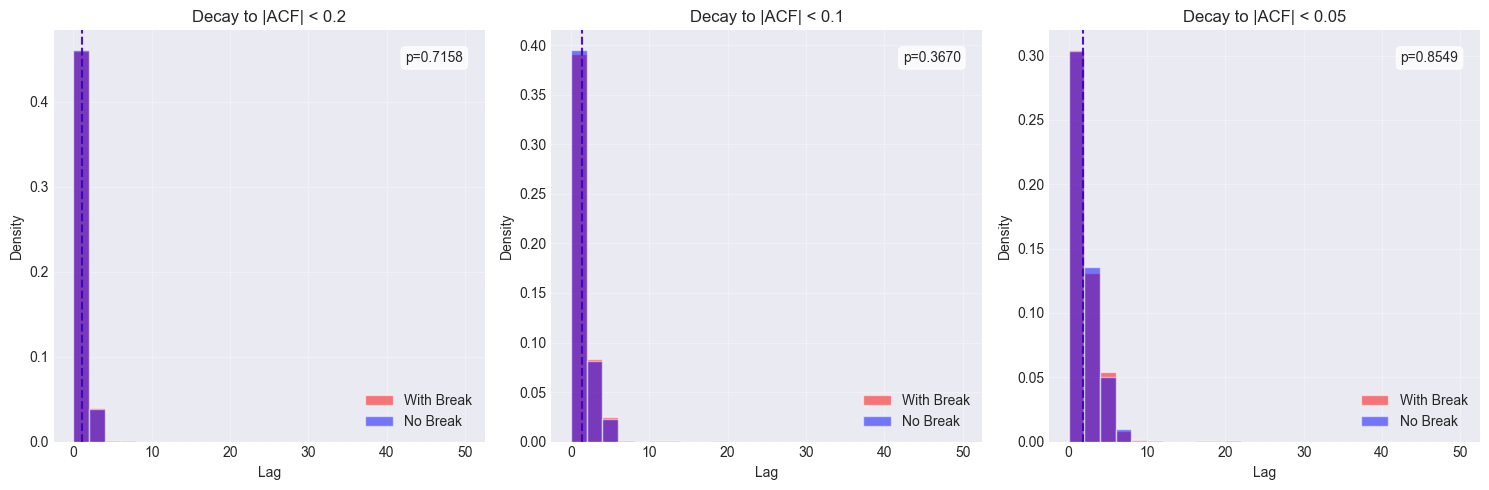

In [16]:
# Analyze decay for different thresholds
thresholds = [0.2, 0.1, 0.05]
fig, axes = plt.subplots(1, len(thresholds), figsize=(15, 5))

for i, threshold in enumerate(thresholds):
    positive_decay = analyze_acf_decay(positive_examples, threshold)
    negative_decay = analyze_acf_decay(negative_examples, threshold)
    
    ax = axes[i]
    
    # Create histograms
    bins = np.linspace(0, 50, 26)
    ax.hist(positive_decay, bins=bins, alpha=0.5, color='red', 
            label='With Break', density=True)
    ax.hist(negative_decay, bins=bins, alpha=0.5, color='blue', 
            label='No Break', density=True)
    
    ax.set_xlabel('Lag')
    ax.set_ylabel('Density')
    ax.set_title(f'Decay to |ACF| < {threshold}')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Add statistics
    pos_mean = np.mean(positive_decay)
    neg_mean = np.mean(negative_decay)
    ax.axvline(pos_mean, color='red', linestyle='--', alpha=0.7)
    ax.axvline(neg_mean, color='blue', linestyle='--', alpha=0.7)
    
    # Statistical test
    u_stat, p_val = stats.mannwhitneyu(positive_decay, negative_decay)
    ax.text(0.95, 0.95, f'p={p_val:.4f}', 
            transform=ax.transAxes, ha='right', va='top',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

9. Summary and Feature Engineering Ideas

In [17]:
print("=== Autocorrelation Analysis Summary ===\n")

print("1. Overall Patterns:")
print(f"   - Mean ACF at lag 1: {all_series_acf['mean_acf'][1]:.3f}")
print(f"   - Mean ACF at lag 5: {all_series_acf['mean_acf'][5]:.3f}")
print(f"   - Mean ACF at lag 10: {all_series_acf['mean_acf'][10]:.3f}")

print("\n2. Break vs No Break Differences:")
print(f"   - ACF lag 1 - With break: {positive_acf['mean_acf'][1]:.3f}, No break: {negative_acf['mean_acf'][1]:.3f}")
print(f"   - ACF lag 5 - With break: {positive_acf['mean_acf'][5]:.3f}, No break: {negative_acf['mean_acf'][5]:.3f}")

print("\n3. Feature Engineering Ideas Based on Autocorrelation:")
print("   - ACF values at specific lags (1, 2, 5, 10, 20)")
print("   - Sum of absolute ACF values (measure of total autocorrelation)")
print("   - Lag where ACF first crosses zero")
print("   - Decay rate of ACF (exponential fit parameters)")
print("   - Difference in ACF between periods")
print("   - PACF values at early lags")
print("   - Ljung-Box test statistics")
print("   - ACF-based stationarity measures")

=== Autocorrelation Analysis Summary ===

1. Overall Patterns:
   - Mean ACF at lag 1: 0.011
   - Mean ACF at lag 5: -0.006
   - Mean ACF at lag 10: 0.002

2. Break vs No Break Differences:
   - ACF lag 1 - With break: 0.011, No break: 0.011
   - ACF lag 5 - With break: -0.006, No break: -0.006

3. Feature Engineering Ideas Based on Autocorrelation:
   - ACF values at specific lags (1, 2, 5, 10, 20)
   - Sum of absolute ACF values (measure of total autocorrelation)
   - Lag where ACF first crosses zero
   - Decay rate of ACF (exponential fit parameters)
   - Difference in ACF between periods
   - PACF values at early lags
   - Ljung-Box test statistics
   - ACF-based stationarity measures


In [20]:
# Create autocorrelation-based features
def extract_acf_features(values, max_lag=20):
    """Extract autocorrelation-based features for a time series."""
    if len(values) < max_lag * 2:
        return {}
    
    # Compute ACF
    acf_values = acf(values, nlags=max_lag, fft=True)
    
    features = {
        'acf_lag1': acf_values[1],
        'acf_lag2': acf_values[2],
        'acf_lag5': acf_values[5] if len(acf_values) > 5 else 0,
        'acf_lag10': acf_values[10] if len(acf_values) > 10 else 0,
        'acf_sum_abs': np.sum(np.abs(acf_values[1:11])),  # Sum of first 10 lags
        'acf_mean': np.mean(acf_values[1:11]),
        'acf_std': np.std(acf_values[1:11]),
    }
    
    # Find first zero crossing
    zero_crossings = np.where(np.diff(np.sign(acf_values[1:])))[0]
    features['acf_first_zero'] = zero_crossings[0] + 1 if len(zero_crossings) > 0 else max_lag
    
    # Ljung-Box test at lag 10
    if len(values) > 20:
        lb_result = acorr_ljungbox(values, lags=10, return_df=False)
        features['ljung_box_stat'] = lb_result.iloc[-1, 0]  # Statistic at lag 10
        features['ljung_box_pvalue'] = lb_result.iloc[-1, 1]  # P-value at lag 10
    
    return features

# Example usage
example_series = list(positive_examples.values())[0]
example_features = extract_acf_features(example_series.values)
print("\nExample ACF features:")
for key, value in example_features.items():
    print(f"  {key}: {value:.4f}")


Example ACF features:
  acf_lag1: -0.1247
  acf_lag2: -0.0031
  acf_lag5: 0.0152
  acf_lag10: 0.0062
  acf_sum_abs: 0.2517
  acf_mean: -0.0095
  acf_std: 0.0411
  acf_first_zero: 2.0000
  ljung_box_stat: 50.7145
  ljung_box_pvalue: 0.0000
